# Nonlinear Model Fitting
 
Nonlinear models typically do not have pleasant analytic posterior distributions. 

Here, we will demonstate three methods for parameter estimation in non-linear models: 

1. Grid search
2. Laplace approximation 
3. MCMC, Metropolis-Hastings

We will be working with the following nonlinear exponential model: 

$$ y = ae^{-bt} + \epsilon $$


### Generating Data







In [9]:
import numpy as np
a = 10
b = 2 
n = 100 
t = np.transpose(np.linspace(0,2,n))
sigma = 0.5

y = a * np.exp(-b*t) + sigma * np.random.randn(n)

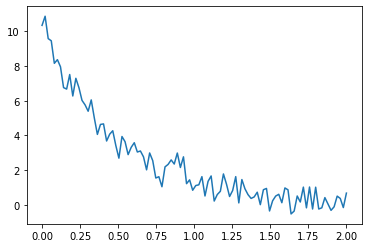

In [10]:
import matplotlib.pyplot as plt 
plt.plot(t, y)
plt.show()


### Grid Search

In [11]:
import numpy as np
w1 = np.linspace(0,20,50)
w2 = np.linspace(0,10,50)

gw1,gw2 = np.meshgrid(w1,w2)
gw1,gw2 = gw1.flatten()[:,None],gw2.flatten()[:,None]
 
grid_n = len(gw1)
t = np.linspace(0,10,100)[:,None]

Y = np.transpose(np.tile(y, (grid_n,1)))

Sample = gw1*np.exp(-gw2@t.T)

mu = np.sum((Y - Sample.T)**2,0) / 2 / sigma**2

likelihood =  np.exp(-mu)

norm_likelihood = likelihood / np.sum(likelihood)

norm_likelihood = np.reshape(norm_likelihood,(50,50))


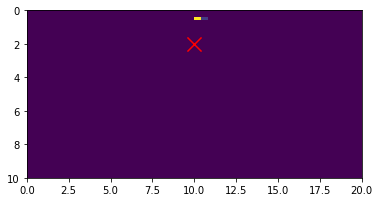

In [12]:
plt.imshow(norm_likelihood,extent=[0,20,10,0])
plt.scatter(a, b, color='r', marker='x', s=200)
plt.show()